In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from IPython.display import HTML
from collections import deque
import importlib
import seaborn as sns #remove
sns.set()
sns.set(style="whitegrid")


%load_ext autoreload
%autoreload 2

In [2]:
import simulation
import controller
from simulation import *
from genetic_utils import *
from dqn_main_bus import DQNMainBus
from main_bus import MainBus
from genetic_main_bus import GeneticMainBus

Using TensorFlow backend.


In [3]:
whole_day = 1440

In [4]:
def get_results(simulation):
    num_del = simulation.controller.num_passengers_delivered
    expenses = simulation.controller.get_total_cost()
    cost_ratio = expenses/num_del
    num_messages = simulation.controller.get_messages_sent()
    awt = (simulation.controller.total_waiting_time ) / \
        (simulation.controller.num_passengers_delivered + simulation.controller.actual_passenger_count)
    return awt, expenses, num_messages, num_del, cost_ratio

# Genetic Approach

initialization of the simulation and the parameters

In [5]:
genetic_simulation = Simulation(GeneticMainBus)
initial_genomes = [[1, 0.5, 0.5, 0.5, 0.5, 0.05], [2, 0.5, 0.5, 0.5, 0.5, 0.08], [3, 0.5, 0.5, 0.5, 0.5, 0.1]]
genome_distro = [0.30, 0.35, 0.35]
np.random.seed(1234)

Initializing Prob Dist


First day iteration

In [6]:
genetic_simulation.reset(bus_genomes=initial_genomes, genome_distro=genome_distro)
genetic_simulation.execute(iterations=whole_day, animate=False)

 1440 / 1440 

{}

Initial Results

In [7]:
awt, expenses, num_messages, num_del, cost_ratio = get_results(genetic_simulation)

print('\n\tDelivered: {}'.format(num_del))
print('\tExpenses: {}'.format(expenses))
print('\tExpenses/Pass Del: {}'.format(cost_ratio))
print('\tMessages: {}'.format(num_messages))
print('\tAWT: {}'.format(awt))

bus_fitness = np.array([bus.cum_reward / MainBus._bus_type_travel_cost[bus.bus_type] for bus in genetic_simulation.controller.buses.values() ])
bus_genomes = np.array([bus.genome for bus in genetic_simulation.controller.buses.values() ])
init_genomes = np.array([bus.genome for bus in genetic_simulation.controller.buses.values() ])

best_perf = awt
best_fitness = bus_fitness
best_genomes = bus_genomes

awt_over_time = [awt]
expenses_over_time = [expenses]
messages_over_time = [num_messages]
delivered_over_time = [num_del]
cost_ratio_over_time = [cost_ratio]


	Delivered: 42196
	Expenses: 1099844
	Expenses/Pass Del: 26.065124656365533
	Messages: 26116
	AWT: 100.73592646564286


Evolutionary algorithm run

In [8]:
n_iterations = 25

# Evolution
for _ in range(n_iterations):
    
    np.random.seed(1234)
    # Evolution step
    (new_genomes, new_distro) = create_new_population(bus_genomes, bus_fitness, 0.7, 0.2, 0.1)
    
    # Evaluation
    genetic_simulation.reset(bus_genomes = new_genomes, genome_distro= new_distro)
    
    genetic_simulation.execute(iterations=whole_day, animate=False)
    
    # Get population stats
    bus_fitness = np.array([bus.cum_reward / MainBus._bus_type_travel_cost[bus.bus_type] for bus in genetic_simulation.controller.buses.values() ])
    bus_genomes = np.array([bus.genome for bus in genetic_simulation.controller.buses.values() ])

    # Display and save results
    awt, expenses, num_messages, num_del, cost_ratio = get_results(genetic_simulation)
    
    awt_over_time.append(awt)
    expenses_over_time.append(expenses)
    messages_over_time.append(num_messages)
    delivered_over_time.append(num_del)
    cost_ratio_over_time.append(cost_ratio)
    
    print('\n\tDelivered: {}'.format(num_del))
    print('\tExpenses: {}'.format(expenses))
    print('\tExpenses/Pass Del: {}'.format(cost_ratio))
    print('\tMessages: {}'.format(num_messages))
    print('\tAWT: {}'.format(awt))
    
    if awt < best_perf:
        best_perf = awt
        best_fitness = bus_fitness
        best_genomes = bus_genomes

 1440 / 1440 
	Delivered: 41954
	Expenses: 1131674
	Expenses/Pass Del: 26.97416217762311
	Messages: 29160
	AWT: 87.65317789485484
 1440 / 1440 
	Delivered: 41788
	Expenses: 1182104
	Expenses/Pass Del: 28.28812099167225
	Messages: 29636
	AWT: 87.6151552516534
 1440 / 1440 
	Delivered: 42227
	Expenses: 1090964
	Expenses/Pass Del: 25.83569753948895
	Messages: 30166
	AWT: 81.3449837462168
 1440 / 1440 
	Delivered: 42246
	Expenses: 1089629
	Expenses/Pass Del: 25.792477394309522
	Messages: 30640
	AWT: 82.67884766281807
 1440 / 1440 
	Delivered: 42237
	Expenses: 1090349
	Expenses/Pass Del: 25.81502000615574
	Messages: 30741
	AWT: 83.09111086201098
 1440 / 1440 
	Delivered: 42340
	Expenses: 1082699
	Expenses/Pass Del: 25.57153991497402
	Messages: 31301
	AWT: 79.44777491312634
 1440 / 1440 
	Delivered: 41481
	Expenses: 1250909
	Expenses/Pass Del: 30.156191991514188
	Messages: 32017
	AWT: 89.03802264320143
 1440 / 1440 
	Delivered: 41409
	Expenses: 1280099
	Expenses/Pass Del: 30.91354536453428
	

print the genome distribution before and after the evolution

79.44777491312634


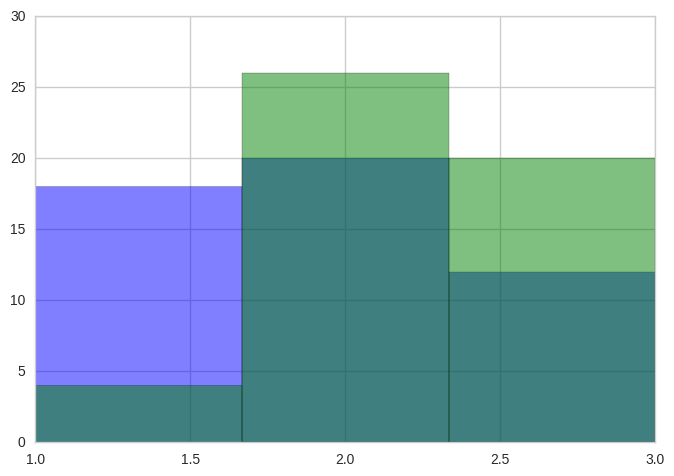

In [9]:
print(best_perf)
plt.hist(init_genomes[:,0], bins=3, alpha = 0.5, color = 'b')
plt.hist(best_genomes[:,0], bins=3, alpha = 0.5, color = 'g')
plt.show()

print of Average Waiting Time of the parameters during the evolution process

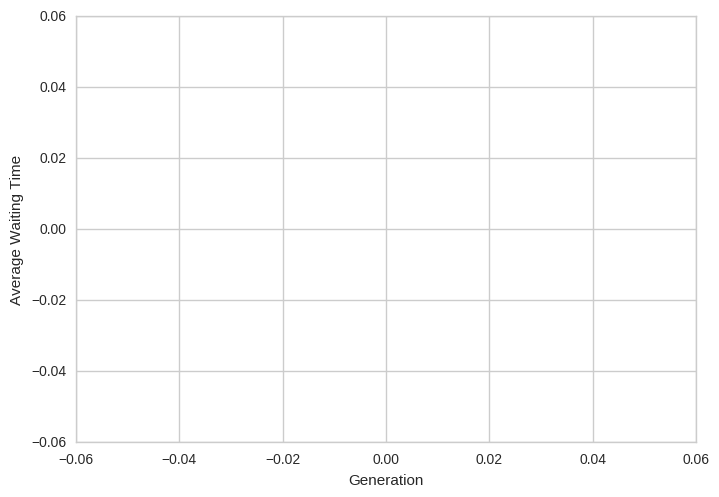

In [27]:
plt.plot(awt_over_time)
plt.xlabel('Generation')
plt.ylabel('Average Waiting Time')
plt.show()

# DQN Approach

Initialization of the simulation and model parameters

In [24]:
dqn_simulation = Simulation(DQNMainBus)

replay_memory = deque(maxlen = 100000)

save_every = 10

exploration_parameter = 0.1
decay_rate = 1e-8
epochs = 100
batch_size=100

iterations=144

awt_over_time = []
expenses_over_time = []
messages_over_time = []
delivered_over_time = []
cost_ratio_over_time = []

Initializing Prob Dist


In [28]:
# Main training loop

for epoch in range(epochs):
    print('Epoch #%d' % (epoch+1))
    day_time = 0
    dqn_simulation.reset() # resets everything
    
    while day_time < whole_day:
        dqn_simulation.execute(iterations=iterations) # simulate and collect logs
        
        replay_memory.extend(dqn_simulation.controller.replay_memory) # store data into replay memory

        if len(replay_memory)  > batch_size:
            # Get random samples
            training_idx = np.random.choice(len(replay_memory), size = batch_size)
            training_samples = [replay_memory[i] for i in training_idx]

            # Train DQN
            dqn_simulation.controller.destination_model.train(training_samples)
            
            # Decrease exploration parameter
            DQNMainBus._EXPLORATION_PARAMETER = exploration_parameter
            exploration_parameter -= 1e-8
        
        day_time += iterations
        
    # Display and save results
    awt, expenses, num_messages, num_del, cost_ratio = get_results(dqn_simulation)
    
    awt_over_time.append(awt)
    expenses_over_time.append(expenses)
    messages_over_time.append(num_messages)
    delivered_over_time.append(num_del)
    cost_ratio_over_time.append(cost_ratio)
    
    print('\n\tDelivered: {}'.format(num_del))
    print('\tExpenses: {}'.format(expenses))
    print('\tExpenses/Pass Del: {}'.format(cost_ratio))
    print('\tMessages: {}'.format(num_messages))
    print('\tAWT: {}'.format(awt))
    
    
    if epoch % save_every == 0:
        simulation.controller.save_destination_model('decision_model_final')
        print('### Saved ###')

Epoch #1
 144 / 144 
	Delivered: 38701
	Expenses: 2047184
	Expenses/Pass Del: 52.89744451047777
	Messages: 12632
	AWT: 147.6641183723798
### Saved ###
Epoch #2
 144 / 144 
	Delivered: 38669
	Expenses: 2055434
	Expenses/Pass Del: 53.15456825881197
	Messages: 12621
	AWT: 149.93610581773345
Epoch #3
 144 / 144 
	Delivered: 38526
	Expenses: 2165144
	Expenses/Pass Del: 56.19955354825313
	Messages: 12511
	AWT: 155.71803609460824
Epoch #4
 144 / 144 
	Delivered: 37340
	Expenses: 2416229
	Expenses/Pass Del: 64.7088644884842
	Messages: 12306
	AWT: 170.07736800807083
Epoch #5
 2 / 144 

KeyboardInterrupt: 

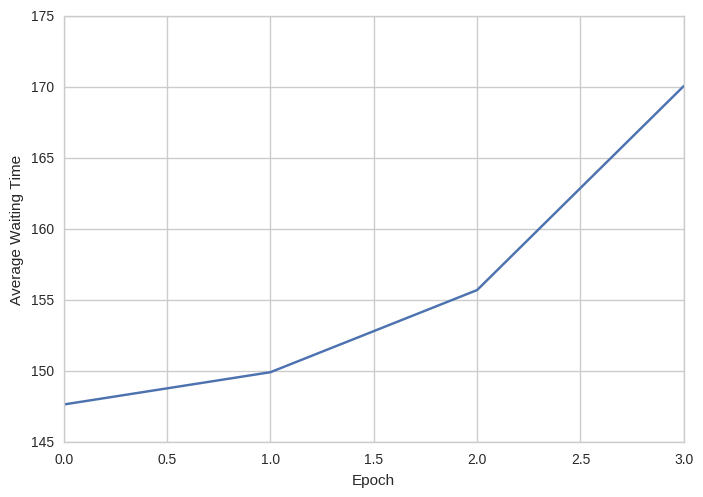

In [30]:
plt.plot(awt_over_time)
plt.xlabel('Epoch')
plt.ylabel('Average Waiting Time')
plt.show()